# Model Pergerakan Harga Saham Binomial Emiten WIKA.JK
### Tugas Besar Pemodelan, Simulasi, dan Optimasi

Anggota Kelompok:
1. Ariq Heritsa Maalik (1305213031)
2. Nadya Khairani (1305210069)
3. Muhammad Baari Adli (1305213081)

In [88]:
# !pip install yfinance
# !pip install pandas-datareader
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# sns.set_style('whitegrid')
sns.set()

In [89]:
ywika = yf.Ticker('BBCA.JK')

# get historical market data
overall = ywika.history(start='2021-06-30', end='2022-12-30')
hist = ywika.history(start='2021-06-30', end='2022-07-02')
actual = ywika.history(start='2022-07-01', end='2022-12-31')

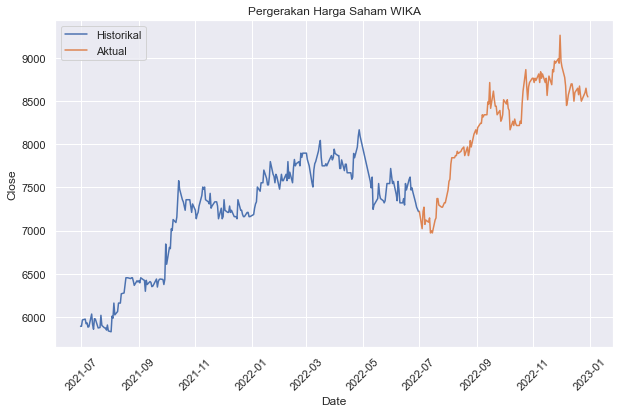

In [90]:
fig, ax = plt.subplots(1, figsize=(10, 6))

sns.lineplot(x=hist.index, y=hist.Close, ax=ax, label='Historikal')
sns.lineplot(x=actual.index, y=actual.Close, ax=ax, label='Aktual')

plt.title('Pergerakan Harga Saham WIKA')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Persiapan Simulasi

In [91]:
sim_days = len(actual)
simulations = 300

r = 0.055 # suku bunga indonesia
T = 1
dt = T / sim_days

### Parameter Model CRR

In [92]:
log_stocks = np.log(np.array([hist.Close[i] for i in range(0,int(len(hist) / 2))]))

sig_crr = np.sqrt(np.std(log_stocks) / 1) # volatilitas harga saham
up_crr = np.exp(sig_crr * np.sqrt(dt))
down_crr = 1 / up_crr
p_crr = (np.exp(r * dt) - down_crr) / (up_crr - down_crr)

print('variansi log saham =', np.std(log_stocks))
print('volatilitas harga saham =', sig_crr)
print('up =', up_crr)
print('down =', down_crr)
print('p =', p_crr)

variansi log saham = 0.08504070240077809
volatilitas harga saham = 0.2916173904292714
up = 1.0259064231523165
down = 0.9747477717580582
p = 0.5018778637617574


### Parameter Metode Empiris

In [93]:
hist['return'] = [hist.Close[i] / hist.Close[i-1] for i in range(1,len(hist))]+[0]
ret = np.array(hist['return'][0:int(len(hist)-1)])

up_empirical = np.mean(ret[ret >= 1])
down_empirical = np.mean(ret[ret < 1])
p_empirical = len(ret[ret >= 1]) / len(ret)
avret = np.mean(ret)

print('mean, std up', np.mean(ret[ret >= 1]), np.std(ret[ret >= 1]))
print('mean, std down', np.mean(ret[ret < 1]), np.std(ret[ret < 1]))

print('up', up_empirical)
print('down', down_empirical)
print('p', p_empirical)
# sigm=(ret-avret)**2

mean, std up 1.0103462606092426 0.010889761340347475
mean, std down 0.9889050937347426 0.009330978650318332
up 1.0103462606092426
down 0.9889050937347426
p 0.5614754098360656


### Faktor Perubahan Harga pada Model Empiris

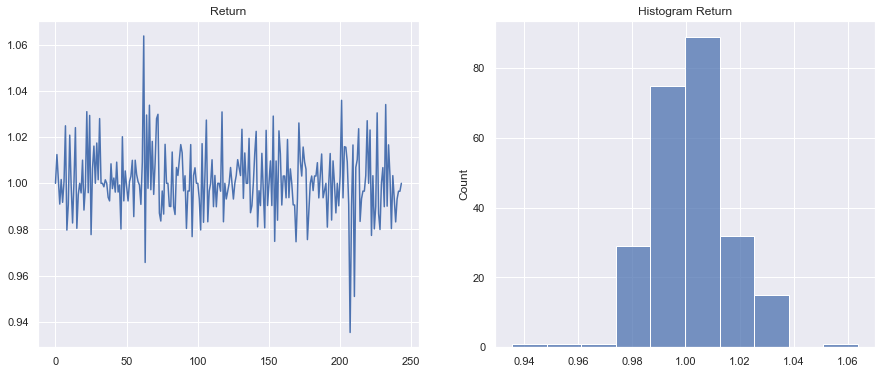

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=ret, ax=ax1)
sns.histplot(data=ret, ax=ax2, bins=10)

ax1.set_title('Return')
ax2.set_title('Histogram Return')

plt.show()

## Membuat Pohon Binomial Saham

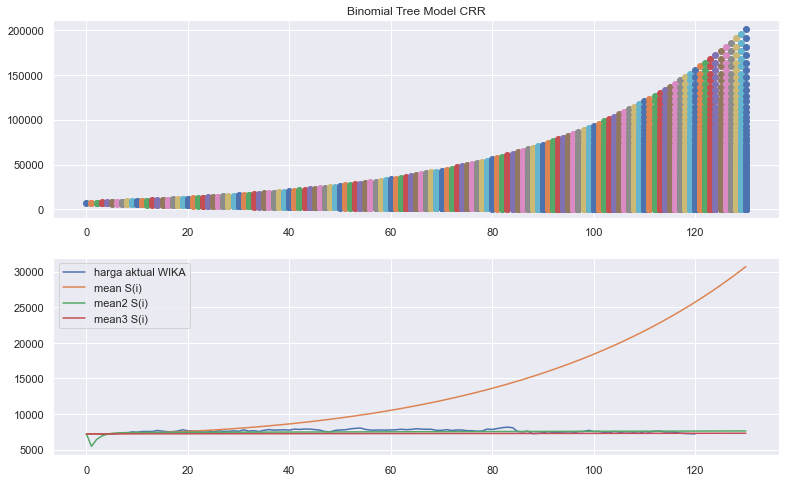

In [95]:
# Membuat pohon Binomial Saham
So = hist.Close[-1]
sig = sig_crr
dt = 1 / sim_days
u = up_crr
d = down_crr
p = p_crr

fig,ax = plt.subplots(2,figsize=(13,8))
price = np.zeros((sim_days+1,sim_days+1), float)
mean_si = np.zeros((sim_days+1), float)
mean2_si = np.zeros((sim_days+1), float)
mean3_si = np.zeros((sim_days+1), float)
mean_si[0] = So
mean2_si[0] = So
mean3_si[0] = So
price[0, sim_days] = So

ax[0].scatter(0, price[0, sim_days])
ax[1].plot(range(len(hist.Close[int(len(hist)/2)+1:-1])), hist.Close[int(len(hist)/2)+1:-1], label='harga aktual WIKA')

for i in range(1,sim_days+1):
  for j in reversed(range(i+1)):
    price[j,i] = So*u**(j)*d**(i-j)

  ax[0].scatter([i for k in range(len(price[0:i+1,i]))], price[0:i+1,i])
  mean_si[i] = np.mean(price[0:i+1,i])
  prob = np.array([math.comb(i+1, i+1-k)*p**(i+1-k)*(1-p)**k for k in range(i+1)])
  
  mean2_si[i] = np.sum(price[0:i+1,i]*prob) 
  mean3_si[i] = So*u**(i*p)*d**(i-i*p)

ax[0].set_title("Binomial Tree Model CRR")
ax[1].plot(mean_si, label='mean S(i)')
ax[1].plot(mean2_si, label='mean2 S(i)')
ax[1].plot(mean3_si, label='mean3 S(i)')
plt.legend()
plt.show()

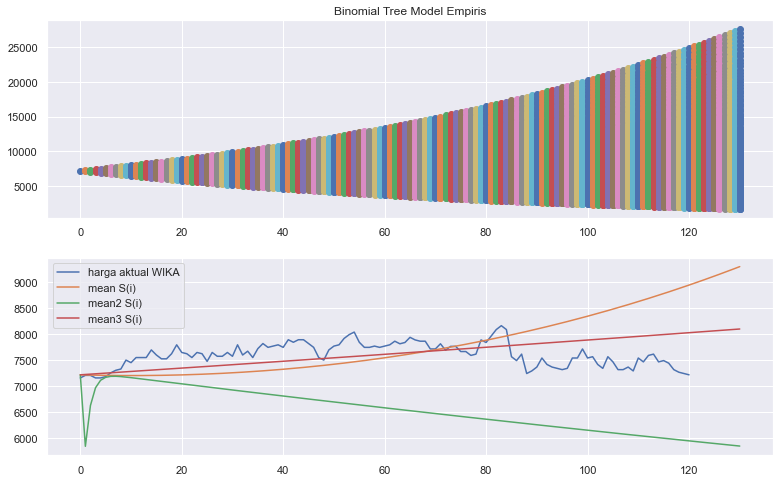

In [96]:
# Membuat pohon Binomial Saham
So = hist.Close[-1]
# sig = sig_crr
dt = 1 / sim_days
u = up_empirical
d = down_empirical
p = p_empirical

fig,ax = plt.subplots(2,figsize=(13, 8))
price = np.zeros((sim_days+1,sim_days+1), float)
mean_si = np.zeros((sim_days+1), float)
mean2_si = np.zeros((sim_days+1), float)
mean3_si = np.zeros((sim_days+1), float)
mean_si[0] = So
mean2_si[0] = So
mean3_si[0] = So
price[0, sim_days] = So
ax[0].scatter(0, price[0, sim_days])
ax[1].plot(range(len(hist.Close[int(len(hist)/2)+1:-1])), hist.Close[int(len(hist)/2)+1:-1], label='harga aktual WIKA')

for i in range(1,sim_days+1):
  for j in reversed(range(i+1)):
    price[j,i] = So*u**(j)*d**(i-j)

  ax[0].scatter([i for k in range(len(price[0:i+1,i]))], price[0:i+1,i])
  mean_si[i] = np.mean(price[0:i+1,i])
  prob = np.array([math.comb(i+1, i+1-k)*p**(i+1-k)*(1-p)**k for k in range(i+1)])
  
  mean2_si[i] = np.sum(price[0:i+1,i]*prob) 
  mean3_si[i] = So*u**(i*p)*d**(i-i*p)

ax[0].set_title("Binomial Tree Model Empiris")
ax[1].plot(mean_si, label='mean S(i)')
ax[1].plot(mean2_si, label='mean2 S(i)')
ax[1].plot(mean3_si, label='mean3 S(i)')
plt.legend()
plt.show()

## Simulation

### Model CRR

In [97]:
So = hist.Close[-1]
u = up_crr
d = down_crr
p = p_crr
smt = []

for k in range(simulations):
  s = So
  sv = [s]
  for i in range(sim_days):
    x = np.random.binomial(i, p)
    s = So * np.power(u, x) * np.power(d, (i-x))
    sv = sv+[s]
  smt = smt+[sv] 

smt = [k for k in smt[1:][:]] 
averages = [np.mean(x) * 2 for x in smt]
avg = np.mean(averages)
std = np.std(averages)
confidence_interval = [avg - 1.96 * std, avg + 1.96 * std]

print('selang kepercayaan 95% =', confidence_interval)

selang kepercayaan 95% = [14316.095957990678, 15392.415756864153]


### Visualisasi

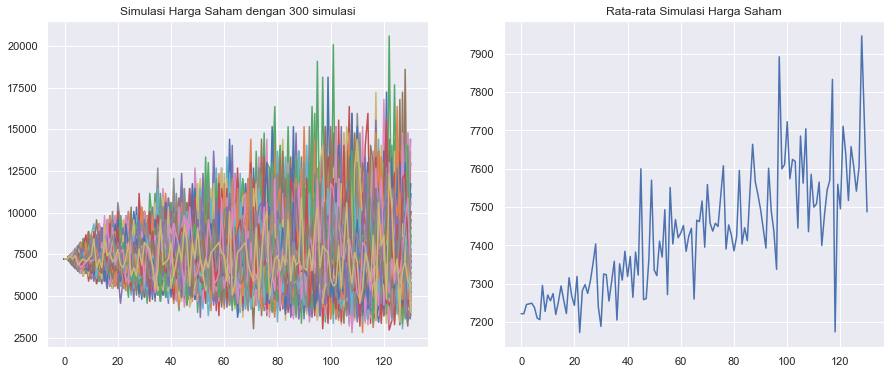

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the paths
[sns.lineplot(data=k, ax=ax1) for k in smt]

# Average path of stock prices
smean_crr = np.mean(np.array(smt), axis=0)

sns.lineplot(data=smean_crr, ax=ax2)

ax1.title.set_text(f'Simulasi Harga Saham dengan {simulations} simulasi')
ax2.title.set_text('Rata-rata Simulasi Harga Saham')

plt.show()

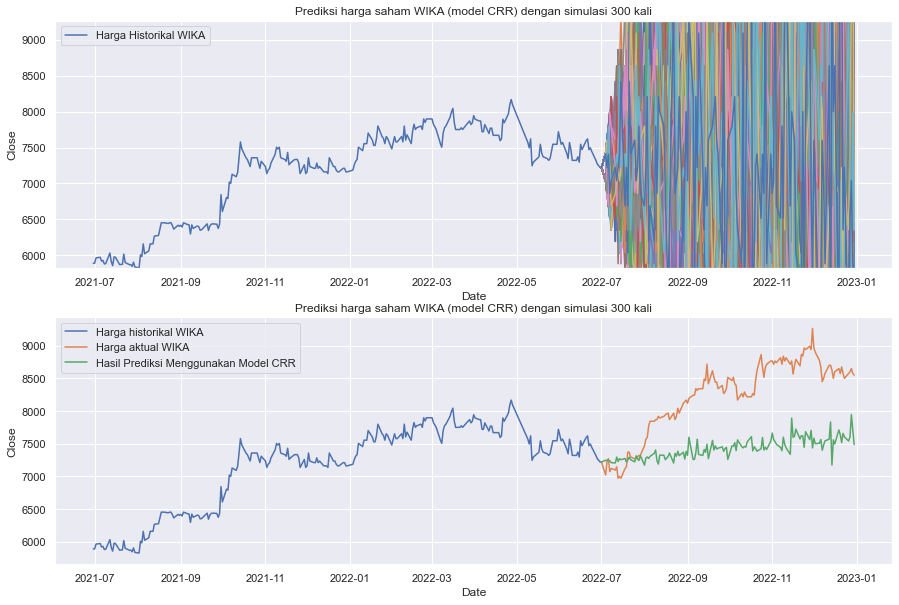

In [99]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

sns.lineplot(data=hist.Close, ax=ax1, label='Harga Historikal WIKA')
sns.lineplot(data=actual.Close, ax=ax1)
[sns.lineplot(data=pd.Series(k[1:], index=actual.index), ax=ax1) for k in smt]

sns.lineplot(data=hist['Close'], label='Harga historikal WIKA', ax=ax2)
sns.lineplot(data=actual['Close'], label='Harga aktual WIKA', ax=ax2)
sns.lineplot(data=pd.Series(smean_crr[1:], index=actual.index), label='Hasil Prediksi Menggunakan Model CRR', ax=ax2)

ax1.set_title(f'Prediksi harga saham WIKA (model CRR) dengan simulasi {simulations} kali')
ax2.set_title(f'Prediksi harga saham WIKA (model CRR) dengan simulasi {simulations} kali')

ax1.set_ylim(top=max(actual.Close.max(), hist.Close.max()), bottom=min(actual.Close.min(), hist.Close.min()))

plt.show()

### Metode Empiris

In [100]:
So = hist.Close[-1]
u = up_empirical
d = down_empirical
p = p_empirical
smt = []

for k in range(simulations):
  s = So
  sv = [s]
  for i in range(sim_days):
    x = np.random.binomial(i, p)
    s = So * np.power(u, x) * np.power(d, (i-x))
    sv = sv+[s]
  smt = smt+[sv] 

smt = [k for k in smt[1:][:]] 
averages = [np.mean(x) * 2 for x in smt]
avg = np.mean(averages)
std = np.std(averages)
confidence_interval = [avg - 1.96 * std, avg + 1.96 * std]

print('selang kepercayaan 95% =', confidence_interval)

selang kepercayaan 95% = [15138.505534018197, 15567.726781551988]


### Visualisasi

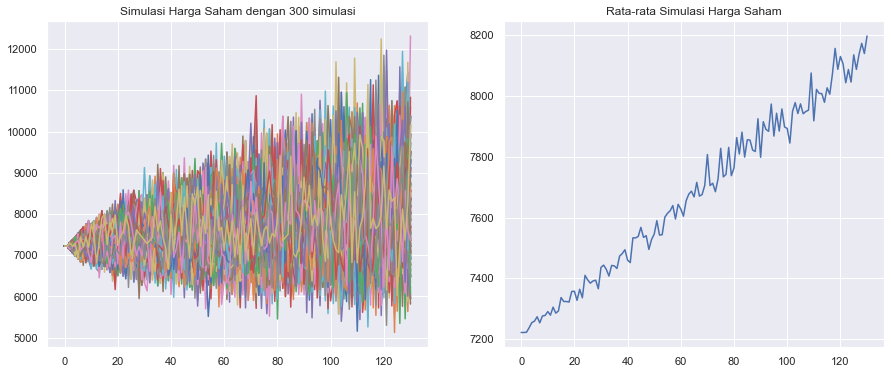

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the paths
[sns.lineplot(data=k, ax=ax1) for k in smt]

# Average path of stock prices
smean_empirical = np.mean(np.array(smt), axis=0)

sns.lineplot(data=smean_empirical, ax=ax2)

ax1.title.set_text(f'Simulasi Harga Saham dengan {simulations} simulasi')
ax2.title.set_text('Rata-rata Simulasi Harga Saham')

plt.show()

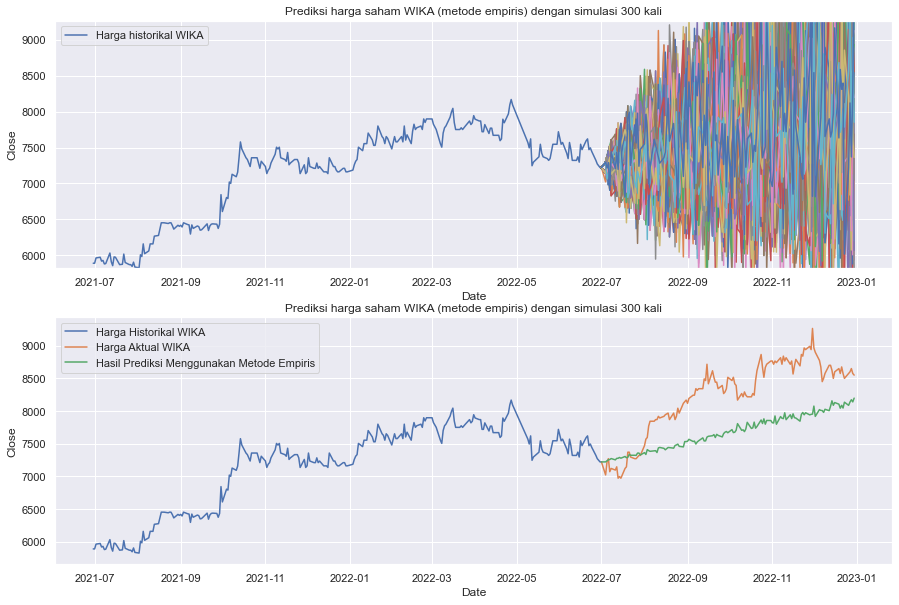

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

sns.lineplot(data=hist['Close'], label='Harga historikal WIKA', ax=ax1)
sns.lineplot(data=actual['Close'], ax=ax1)
[sns.lineplot(data=pd.Series(k[1:], index=actual.index), ax=ax1) for k in smt]

sns.lineplot(data=hist['Close'], label='Harga Historikal WIKA', ax=ax2)
sns.lineplot(data=actual['Close'], label='Harga Aktual WIKA', ax=ax2)
sns.lineplot(data=pd.Series(smean_empirical[1:], index=actual.index), label='Hasil Prediksi Menggunakan Metode Empiris', ax=ax2)

ax1.set_title(f'Prediksi harga saham WIKA (metode empiris) dengan simulasi {simulations} kali')
ax2.set_title(f'Prediksi harga saham WIKA (metode empiris) dengan simulasi {simulations} kali')

ax1.set_ylim(top=max(actual.Close.max(), hist.Close.max()), bottom=min(actual.Close.min(), hist.Close.min()))

plt.show()

## Perbandingan Model CRR dan Metode Empiris

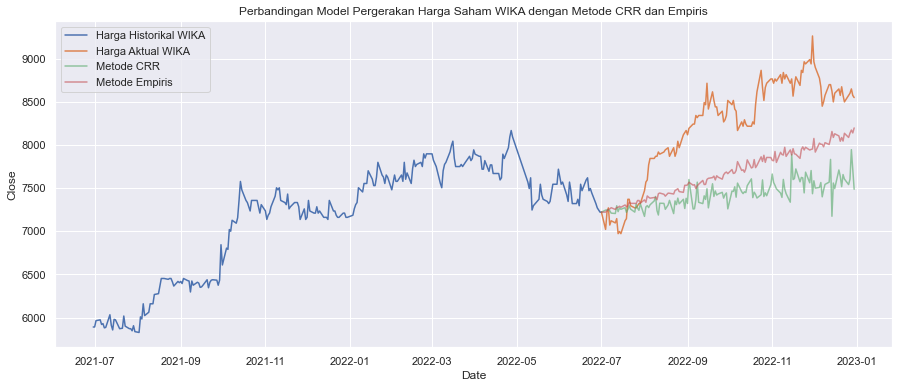

In [103]:
fig = plt.figure(figsize=(15, 6))

sns.lineplot(data=hist['Close'], label='Harga Historikal WIKA')
sns.lineplot(data=actual['Close'], label='Harga Aktual WIKA')

sns.lineplot(data=pd.Series(smean_crr[1:], index=actual.index), label='Metode CRR', alpha=0.6)
sns.lineplot(data=pd.Series(smean_empirical[1:], index=actual.index), label='Metode Empiris', alpha=0.6)

plt.title('Perbandingan Model Pergerakan Harga Saham WIKA dengan Metode CRR dan Empiris')

plt.show()

## Perhitungan Error

### Error pada model CRR

In [104]:
actual_crr = ywika.history(start='2022-07-01', end='2022-12-31')
crr = pd.Series(smean_crr[1:], index=actual_crr.index)

# drop columns
actual_crr = actual_crr.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

# add empiris
actual_crr['CRR'] = crr

actual_crr['Diff'] = actual_crr['Close'] - actual_crr['CRR']
actual_crr['Squared'] = actual_crr['Diff'] ** 2
actual_crr['Absolute Percent Error'] = np.abs(actual_crr['Diff']) / actual_crr['Close'] * 100

mse = actual_crr['Squared'].sum() / len(actual_crr)
mape = actual_crr['Absolute Percent Error'].sum() / len(actual_crr)

print(f'MSE = {mse:.2f}')
print(f'MAPE = {mape:.2f}%')

MSE = 858296.23
MAPE = 9.79%


### Error pada metode empiris

In [105]:
actual_empiris = ywika.history(start='2022-07-01', end='2022-12-31')
empiris = pd.Series(smean_empirical[1:], index=actual_empiris.index)

# drop columns
actual_empiris = actual_empiris.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

# add empiris
actual_empiris['Empiris'] = empiris

actual_empiris['Diff'] = actual_empiris['Close'] - actual_empiris['Empiris']
actual_empiris['Squared'] = actual_empiris['Diff'] ** 2
actual_empiris['Absolute Percent Error'] = np.abs(actual_empiris['Diff']) / actual_empiris['Close'] * 100

mse = actual_empiris['Squared'].sum() / len(actual_empiris)
mape = actual_empiris['Absolute Percent Error'].sum() / len(actual_empiris)

print(f'MSE = {mse:.2f}')
print(f'MAPE = {mape:.2f}%')

MSE = 427043.93
MAPE = 6.93%


## Kesimpulan

Perhitungan error pada metode empiris lebih kecil dibandingkan dengan model CRR. Hal ini dikarenakan metode empiris lebih akurat dalam memprediksi pergerakan harga saham.